In [3]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt


--- Gotowy, połączony zbiór danych (miesięcznie) ---
            CPIAUCSL     DGS10  FEDFUNDS    T10Y2Y  UNRATE
date                                                      
2000-01-01     169.3  6.662381      5.45  0.222381     4.0
2000-02-01     170.0  6.518095      5.73 -0.094762     4.1
2000-03-01     171.0  6.256522      5.85 -0.271739     4.0
2000-04-01     170.9  5.992381      6.02 -0.414762     3.8
2000-05-01     171.2  6.435652      6.27 -0.368696     4.0

Zakres danych: od 2000-01-01 do 2025-11-01

Generowanie wykresu dla pełnego zbioru danych...
  Zapisano wykres jako 'full_data_plot.png'


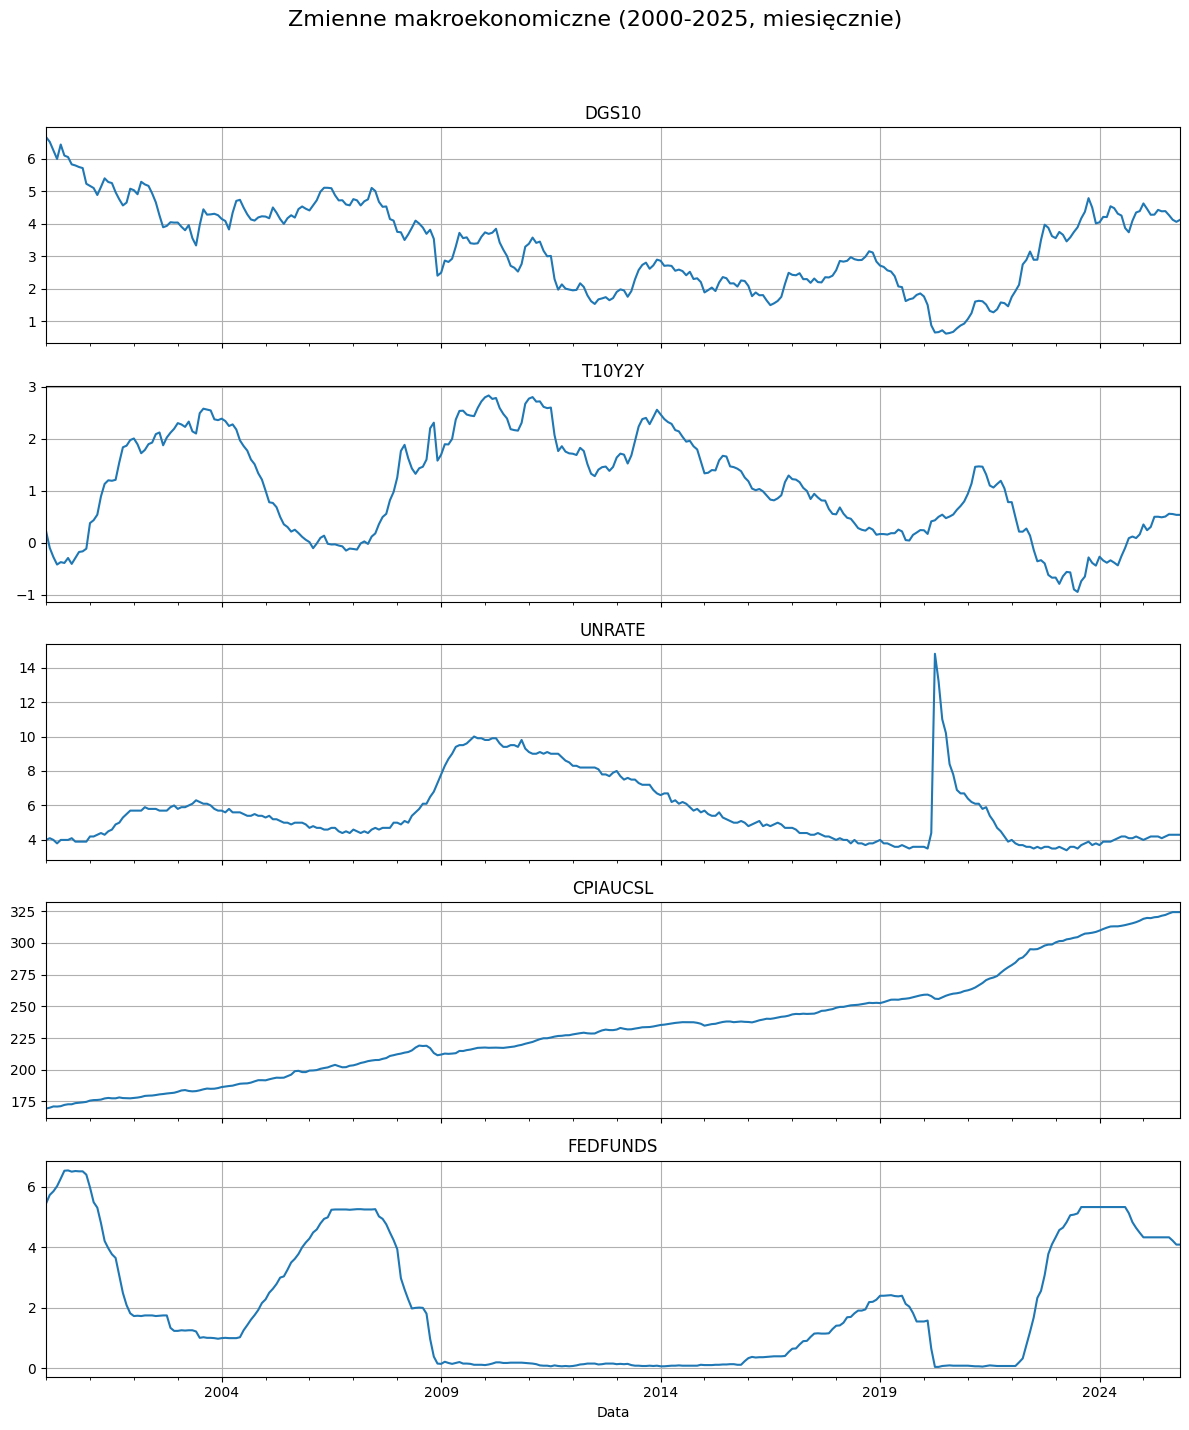

In [4]:
#na s3 to bedzie docelowo inne miejsce to na potrzeby testow 
my_dir = 'C:/Users/kacpe/projScriptsNeo/fred_local_data/'

# Lista zmiennych, do uzycia
vars_to_load = ['DGS10', 'T10Y2Y', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS']

# Użyj glob do znalezienia wszystkich plików .csv w folderze
# os.path.join poprawnie łączy ścieżkę i wzorzec '*.csv'
file_pattern = os.path.join(my_dir, '*.csv')
file_paths = glob.glob(file_pattern)

if not file_paths:
    print(f"Nie znaleziono żadnych plików .csv w folderze: {my_dir}")
else:
    all_dfs = [] 

    for file in file_paths:
        # Wyciągnij nazwę serii z nazwy pliku bez daty
        series_id = os.path.basename(file).split('_')[0]

        if series_id in vars_to_load:
            try:
                df = pd.read_csv(file, parse_dates=['date'], index_col='date')
                df = df.rename(columns={'value': series_id})
                all_dfs.append(df)
            except Exception as e:
                print(f"  Błąd wczytania {file}: {e}")

    if not all_dfs:
        print("BŁĄD: Nie udało się wczytać żadnych pasujących danych.")
    else:
        df_combined = pd.concat(all_dfs, axis=1).sort_index()
        df_filled = df_combined.ffill()

        # Zresampluj wszystko do początku miesiąca 
        # Dla danych dziennych policzy średnią z miesiąca
        # Dla danych miesięcznych po prostu wybierze wartość
        df_monthly = df_filled.resample('MS').mean()
        #Usuń wiersze, gdzie brakuje danych 
        df_final = df_monthly.dropna()

        print("\n--- Gotowy, połączony zbiór danych (miesięcznie) ---")
        print(df_final.head())
        print(f"\nZakres danych: od {df_final.index.min().date()} do {df_final.index.max().date()}")

        # Wizualizacja (Cały zbiór 2000-2025) 
        print("\nGenerowanie wykresu dla pełnego zbioru danych...")
        
        fig, axes = plt.subplots(nrows=len(vars_to_load), ncols=1, figsize=(12, 15), sharex=True)
        fig.suptitle('Zmienne makroekonomiczne (2000-2025, miesięcznie)', fontsize=16)
        
        for i, col in enumerate(vars_to_load):
            if col in df_final:
                df_final[col].plot(ax=axes[i], title=col)
                axes[i].grid(True)
        
        plt.xlabel('Data')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig('full_data_plot.png')
        print("  Zapisano wykres jako 'full_data_plot.png'")


